## Create SVM Classifier
By extracting features from the z-maps, we will train the SVM to classify
between normal and abnormal voxels.

In [2]:
import re
from sklearn.metrics import accuracy_score
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import os
from sklearn.svm import SVC
from sklearn import metrics

Create X_train, y_train, X_test, y_test

In [26]:
# manually separate X_train, y_train, X_test and y_test to make sure
# that entire patients are separated into train and test and not just
# random voxels

train_data = pd.read_csv('train-data.csv', index_col=[0])
test_data = pd.read_csv('test-data.csv', index_col=[0])

print("Creating X_train, X_test, y_train, y_test...")
y_train = train_data.target
y_test = test_data.target

# remove labels from x_train and x_test
X_train = train_data.drop(['target', 'target_name'], axis='columns')
X_test = test_data.drop(['target', 'target_name'], axis='columns')
print("X_train, X_test, y_train, y_test created")

Creating X_train, X_test, y_train, y_test...
X_train, X_test, y_train, y_test created


In [4]:
## code to generate best parameters for model using GridSearch
# from sklearn.model_selection import GridSearchCV
# Cs = np.logspace(-6, -1, 10)
# svc = SVC(kernel='rbf')
# clf = GridSearchCV(svc, param_grid=dict(C=Cs), n_jobs=-1)
# clf.fit(X_train, y_train)
# print(clf.best_score_)
# print(clf.best_estimator_.C)
# def svc_param_selection(X, y, nfolds):
#     Cs = [0.001, 0.01, 0.1, 1, 10]
#     gammas = [0.001, 0.01, 0.1, 1]
#     param_grid = {'C': Cs, 'gamma' : gammas}
#     grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
#     grid_search.fit(X, y)
#     grid_search.best_params_
#     return grid_search.best_params_
#svc_param_selection(X_train, y_train, 5)

Training

In [4]:
# Model w/ RBF kernel, set probabilistic output to true
p_clf = SVC(kernel='rbf', gamma=0.1, C=0.0077, probability=True)
print("Starting to train...")
p_clf.fit(X_train, y_train)
print("Training complete.")

Starting to train...
Training done


Validation

In [6]:
# use stratified 5-fold cv as validation method
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
print("Starting validation process...")
scores = cross_val_score(p_clf, X_train, y_train, cv=skf)
print("Validation complete.")
print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Starting validation process...
Validation completed.
Validation Accuracy: 0.79 (+/- 0.16)


Testing

In [7]:
# TESTING
print("Starting to test...")
# binary output
y_pred_binary = p_clf.predict(X_test)
# probabilistic output
y_pred = p_clf.predict_proba(X_test)
print("Testing complete.")
print("Testing Accuracy:", accuracy_score(y_test, y_pred_binary))

Starting to test...
Testing completed
Testing Accuracy: 0.8635361993669618


In [21]:
# Calculate confusion matrix and generate classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
tn, fp, fn, tp = conf_matrix.ravel()
print("True negative: ", tn)
print("False positive: ", fp)
print("False negative: ", fn)
print("True positive: ", tp)
print("Specificity (true neg rate): ", tn / (tn + fp))
print("Sensitivity: (true pos rate)", tp / (tp + fn))
print("--------------------------------------------------------")

print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_binary, target_names=['CONTROL', 'DISCRETE']))
print("--------------------------------------------------------")
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred_binary, labels=[0, 1]),
)
print("CONFUSION MATRIX")
print(cmtx)

True negative:  13697
False positive:  756
False negative:  2650
True positive:  7856
Specificity (true neg rate):  0.9476925205839618
Sensitivity: (true pos rate) 0.7477631829430802
--------------------------------------------------------
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     CONTROL       0.84      0.95      0.89     14453
    DISCRETE       0.91      0.75      0.82     10506

    accuracy                           0.86     24959
   macro avg       0.88      0.85      0.86     24959
weighted avg       0.87      0.86      0.86     24959

--------------------------------------------------------
CONFUSION MATRIX
       0     1
0  13697   756
1   2650  7856


AUC: 0.896


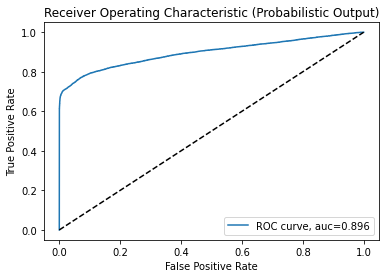

In [9]:
# ROC Curve for probabilistic output
import matplotlib.pyplot as plt
auc = metrics.roc_auc_score(y_test, y_pred[:,1])
print('AUC: %.3f' % auc)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred[:,1])
auc = metrics.roc_auc_score(y_test, y_pred[:,1])
plt.plot(fpr,tpr,label="ROC curve, auc="+str(auc)[0:5])
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Probabilistic Output)')
plt.savefig('ROC_curve_prob.png')

AUC: 0.848


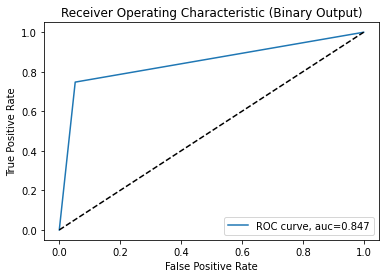

In [10]:
# ROC Curve for binary output
auc = metrics.roc_auc_score(y_test, y_pred_binary)
print('AUC: %.3f' % auc)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_binary)
auc = metrics.roc_auc_score(y_test, y_pred_binary)
plt.plot(fpr,tpr,label="ROC curve, auc="+str(auc)[0:5])
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Binary Output)')
plt.savefig('ROC_curve_binary.png')

In [11]:
# save model for use in testing.ipynb so we don't have to keep retraining and waste time
import joblib
joblib.dump(p_clf, 'p-rbf-clf.joblib')




['p-rbf-clf.joblib']